In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchdiffeq import odeint
from torch.nn.parameter import Parameter
import gpytorch

from reggae.data_loaders import load_barenco_puma, DataHolder

from matplotlib import pyplot as plt

import tensorflow_probability as tfp
import numpy as np

f64 = np.float64

torch.Size([3, 5, 7])
tensor([[0.0000],
        [0.1667],
        [0.3333],
        [0.5000],
        [0.6667],
        [0.8333],
        [1.0000]], dtype=torch.float64)


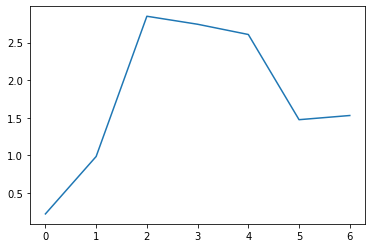

In [2]:
m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma('../data/')

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = torch.tensor(m_observed)
f_observed = torch.tensor(f_observed)
data = (m_observed, f_observed)

σ2_m_pre = f64(σ2_m_pre)
σ2_f_pre = f64(σ2_f_pre)
noise_data = (σ2_m_pre, σ2_f_pre)

print(m_observed.shape)

num_genes = m_observed.shape[1]
num_tfs = f_observed.shape[1]
N_m = m_observed.shape[2]
granularity = 100
t_start = f64(0)
t_end = f64(1)
t = torch.linspace(t_start, t_end, granularity, dtype=torch.float64).view((-1, 1))
t_inducing = torch.linspace(t_start, t_end, 7, dtype=torch.float64).reshape((-1, 1))
print(t_inducing)
plt.plot(m_observed[0,0])

In [38]:
def positivity_transform(value):
    return torch.log(1+torch.exp(value))

def plot_genes():
    initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64
    outputs = torch.squeeze(model(t.view(-1), initial_value))
    print(outputs.shape)
    plt.figure(figsize=(5, 8))
    for i in range(num_genes):
        plt.subplot(511+i)
        plt.plot(t, torch.squeeze(outputs[0]).detach())
        plt.scatter(t_inducing, m_observed[0][i])

In [24]:
class GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y):
        super(GP, self).__init__(train_x, train_y, gpytorch.likelihoods.GaussianLikelihood())
        self.mean_module = gpytorch.means.ConstantMean()
        rbf = gpytorch.kernels.RBFKernel(eps=0.15) # eps is min lengthscale
        rbf.lengthscale = f64(0.2)
        self.covar_module = gpytorch.kernels.ScaleKernel(rbf)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ODEModel(nn.Module):
    """
    Description blah
    Parameters
    ----------
    num_genes : int
    Number of genes.
    num_tfs : int

    t_inducing : int
    inducing timepoints.
    """
    def __init__(self, num_genes, num_tfs, t_inducing):
        super(ODEModel, self).__init__()
        self.num_genes = num_genes
        self.num_tfs = num_tfs
        self.num_inducing = 7
        self.inducing_sources = t_inducing

        self.decay_rate = Parameter(1*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.basal_rate = Parameter(0.2*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.sensitivity = Parameter(2*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.w = Parameter(torch.ones((self.num_genes, self.num_tfs), dtype=torch.float64))
        self.w_0 = Parameter(torch.ones((self.num_tfs), dtype=torch.float64))
        self.inducing_targets = 3+Parameter(torch.randn(self.num_inducing, dtype=torch.float64))
        self.gp = GP(self.inducing_sources.view(-1), self.inducing_targets)
        self.nfe = 0

    def forward(self, t, h):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor
            Shape (num_genes, 1)
        Returns
        -------
        Returns mu and sigma for output distribution. Both have shape
        (batch_size, num_points, y_dim).
        """
        self.nfe = 0
        num_times = t.size()


        # Integrate forward from the batch of initial positions z.
        h = odeint(self.odefunc, h, t, method='dopri5') # shape (num_genes, num_times, 1
        return torch.transpose(h, 0, 1)

    def odefunc(self, t, h):
        self.nfe += 1
        # print(t)

        # h is of shape (num_genes, 1)
        decay = torch.multiply(self.decay_rate.view(-1), h.view(-1)).view(-1, 1)

        p = self.get_tfs(t)
        # print(p.shape)
        Gp = self.G(p)
        # print(Gp.shape)
        # print(self.basal_rate, Gp, decay)

        return self.basal_rate + self.sensitivity * Gp - decay

    def get_tfs(self, at):
        self.gp.set_train_data(self.inducing_sources, self.inducing_targets)
        f_mvn = self.gp(self.inducing_sources) #

        self.gp.eval() # activate posterior mode (calls to gp() will be posterior predictive)

        # print(at.shape, self.inducing_targets.shape)
        inputs = torch.cat([self.inducing_targets, at.view(-1)])
        # f_mvn = self.gp(at.view(-1))
        f_mvn = self.gp(inputs)
        # print(f_mvn.mean.shape)

        self.gp.train()

        return torch.unsqueeze(f_mvn.mean[-1], 0) #TODO support multi tfs, in which case the 0 dim is num_tfs

    def G(self, p):
        # p_pos = positivity_transform(p)
        # interactions = torch.matmul(self.w, torch.log(p_pos+1e-50)) + self.w_0 #(TODO)
        # return torch.sigmoid(interactions) # TF Activation Function (sigmoid)
        return p

    def latent(self, t):
        self.gp.eval()
        f_mvn = self.gp(t)
        return positivity_transform(f_mvn.mean)

    def train(self, mode=True):
        self.gp.train(mode)
        self.gp.likelihood.train(mode)
        super().train(mode)

In [25]:
def train(optimizer, loss_fn, epochs=10):
    basalrates = list()
    decayrates = list()
    lengthscales = list()
    plt.figure()
    plt.plot(t_inducing, m_observed[0,0], label='real')

    for epoch in range(epochs):
        optimizer.zero_grad()
        # Output from model
        initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64
        output = torch.squeeze(model(t_inducing.view(-1), initial_value))

        # Calc loss and backprop gradients
        loss = loss_fn(output, m_observed[0])

        loss.backward()
        print('Epoch %d/%d - Loss: %.3f %.3f b: %.2f d %.2f λ: %.3f noise: %.3f' % (
            epoch + 1, epochs, loss.item(),
            output[0,3].item(),
            model.basal_rate[0].item(),
            model.decay_rate[0].item(),
            model.gp.covar_module.base_kernel.lengthscale.item(),
            model.gp.likelihood.noise.item()
        ))
        optimizer.step()

        basalrates.append(model.basal_rate.detach().numpy())
        decayrates.append(model.decay_rate.detach().numpy())
        lengthscales.append(model.gp.covar_module.base_kernel.lengthscale.item())
        if (epoch % 10) ==0:
            plt.plot(t_inducing, output[0].detach().numpy(), label='epoch'+str(epoch))

    plt.legend()
    return output, (basalrates, decayrates, lengthscales)

In [26]:
model = ODEModel(num_genes, num_tfs, t_inducing)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters
loss_fn = torch.nn.MSELoss()

### Outputs prior to training:

torch.Size([5, 100])


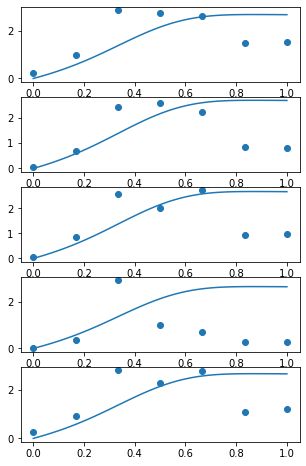

In [27]:
plot_genes()

Epoch 1/50 - Loss: 0.388 2.706 b: 0.76 d 3.94 λ: 0.168 noise: 0.693
Epoch 2/50 - Loss: 0.386 2.710 b: 0.76 d 3.96 λ: 0.167 noise: 0.693
Epoch 3/50 - Loss: 0.384 2.715 b: 0.76 d 3.98 λ: 0.167 noise: 0.693
Epoch 4/50 - Loss: 0.382 2.719 b: 0.76 d 4.00 λ: 0.167 noise: 0.693
Epoch 5/50 - Loss: 0.380 2.723 b: 0.76 d 4.02 λ: 0.167 noise: 0.693
Epoch 6/50 - Loss: 0.379 2.727 b: 0.76 d 4.04 λ: 0.167 noise: 0.693
Epoch 7/50 - Loss: 0.377 2.731 b: 0.76 d 4.06 λ: 0.166 noise: 0.693
Epoch 8/50 - Loss: 0.375 2.735 b: 0.76 d 4.08 λ: 0.166 noise: 0.693
Epoch 9/50 - Loss: 0.373 2.739 b: 0.76 d 4.10 λ: 0.166 noise: 0.693
Epoch 10/50 - Loss: 0.371 2.743 b: 0.76 d 4.12 λ: 0.166 noise: 0.693
Epoch 11/50 - Loss: 0.369 2.747 b: 0.76 d 4.14 λ: 0.165 noise: 0.693
Epoch 12/50 - Loss: 0.368 2.751 b: 0.76 d 4.16 λ: 0.165 noise: 0.693
Epoch 13/50 - Loss: 0.366 2.755 b: 0.76 d 4.18 λ: 0.165 noise: 0.693
Epoch 14/50 - Loss: 0.364 2.759 b: 0.76 d 4.19 λ: 0.165 noise: 0.693
Epoch 15/50 - Loss: 0.362 2.763 b: 0.76 d 4

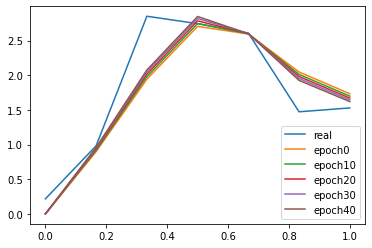

In [39]:
output, params = train(optimizer, loss_fn, 50)

In [40]:
print(model.gp.covar_module.base_kernel.lengthscale)

tensor([[0.1600]], grad_fn=<SoftplusBackward>)


torch.Size([7])


Text(0.5, 1.0, 'Latent')

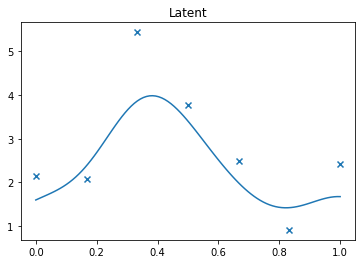

In [41]:
print(model.inducing_targets.shape)
plt.figure()
plt.plot(t, model.latent(t).detach())
plt.scatter(t_inducing, model.inducing_targets.detach(), marker='x')
plt.title('Latent')

/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


torch.Size([5, 100])


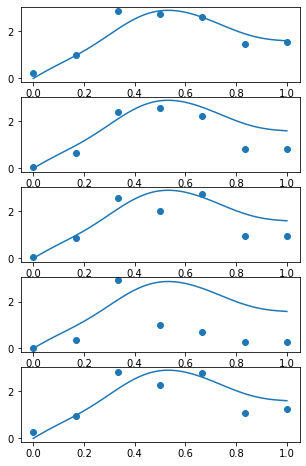

In [42]:
plot_genes()

torch.Size([100, 1])


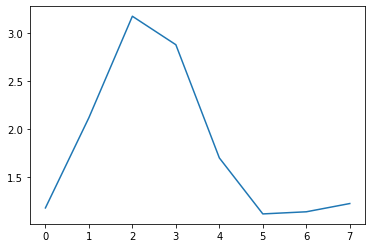

In [32]:
print(t.shape)

t_ = torch.cat([t_inducing, torch.tensor([0.01], dtype=torch.float64).view(-1,1)])
model.gp.eval()
plt.plot(model.gp(t_).mean.detach())

Parameter containing:
tensor([[4.7924],
        [4.4265],
        [4.3853],
        [3.1749],
        [4.6840]], dtype=torch.float64, requires_grad=True)
torch.Size([5, 1]) torch.Size([1])
torch.Size([5])
torch.Size([1])


IndexError: too many indices for tensor of dimension 1

In [ ]:
plt.figure(figsize=(5, 6))
basal, decay, lengthscale = params
basals = np.array(basal)
decays = np.array(decay)
lengthscales = np.array(lengthscale)
print(lengthscales.shape)
plt.subplot(311)
# print(basals[:,0])
plt.plot(basals[:,0])
# plt.ylim(1, 1.5)
plt.subplot(312)
plt.plot(decays[:,0])
# plt.ylim(0.5, 1)
plt.subplot(313)
plt.plot(lengthscales)
# plt.ylim(1, 1.2)

print(model.basal_rate)


In [96]:
model.w

Parameter containing:
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=torch.float64, requires_grad=True)

In [89]:
model.sensitivity
# model.gp.covar_module.outputscale

Parameter containing:
tensor([[8.9318],
        [9.4879],
        [9.1635],
        [5.7552],
        [9.1064]], dtype=torch.float64, requires_grad=True)